In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# model itself
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from keras.losses import mean_absolute_percentage_error
from keras import backend as K

Using TensorFlow backend.


In [2]:
df = pd.read_csv('pvdaq_2012_2014_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

In [3]:
df.dtypes

SiteID                 float64
ac_current             float64
ac_power               float64
ac_voltage             float64
ambient_temp           float64
dc_current             float64
dc_power               float64
dc_voltage             float64
inverter_error_code    float64
inverter_temp          float64
module_temp            float64
poa_irradiance         float64
power_factor           float64
relative_humidity      float64
wind_direction         float64
wind_speed             float64
dtype: object

In [4]:
# columns to use for forecasting
cols = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance', 
        'relative_humidity', 'wind_direction', 'wind_speed']
time_indexes = [df.index.hour, df.index.month]
# we will forecast dc power output
target = ['dc_power']

In [5]:
# array stacking
def create_sequence(df, cols, target):
  seqs = []
  for col in cols:
    seq = df[col].values.reshape((len(df[col]), 1))
    seqs.append(seq)
  for index in time_indexes:
    seq = index.values.reshape((len(df[col]), 1))
    seqs.append(seq)
  seq = df[target].values.reshape((len(df[target]), 1))
  for i in range(len(seq)):
    if seq[i] < 0:
      seq[i] = 0
  seqs.append(seq)
  dataset = np.hstack((seqs))  
  return dataset

dataset = (create_sequence(df, cols, target))

In [6]:
dataset.shape

(26304, 10)

In [7]:
# single step multivariate sequence
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    # check if we are not beyond range
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix ,-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [8]:
X, y = split_sequence(dataset, 4)
print(X. shape, y.shape)

(26300, 4, 10) (26300,)


In [9]:
print(df.head(1), y[11])

            SiteID  ac_current  ac_power  ac_voltage  ambient_temp  \
Date-Time                                                            
2012-01-01  1277.0         0.0    -150.0       285.5      4.437502   

            dc_current  dc_power  dc_voltage  inverter_error_code  \
Date-Time                                                           
2012-01-01        -1.0    -100.0        0.25                  0.0   

            inverter_temp  module_temp  poa_irradiance  power_factor  \
Date-Time                                                              
2012-01-01           16.5     0.208335             0.0           0.0   

            relative_humidity  wind_direction  wind_speed  
Date-Time                                                  
2012-01-01             44.628        306.7035    0.565841   3400.0


In [10]:
def split_sequence_multi(sequence, n_steps, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    out_ix = end_ix + n_steps_out
    # boundary check
    if out_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y) 

In [11]:
X, y = split_sequence_multi(dataset, 12, 6)
print(X.shape, y.shape)

(26287, 12, 10) (26287, 6)


In [12]:
X[0][0], y[0]

(array([4.43750176e+00, 1.65000000e+01, 2.08334750e-01, 0.00000000e+00,
        4.46280000e+01, 3.06703500e+02, 5.65840880e-01, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00]),
 array([22600., 18175., 13400.,  3400.,   125.,     0.]))

In [13]:
X.shape, y.shape

((26287, 12, 10), (26287, 6))

In [22]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
n_features=X.shape[2]
X, y = split_sequence_multi(dataset, n_steps, n_steps_out)
train_X, train_y = X[:-2000,:], y[:-2000,:]
val_X, val_y = X[-2000:-1000,:], y[-2000:-1000,:]
test_X, test_y = X[-1000:,:], y[-1000:,:]

model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(train_X, train_y, batch_size=32, epochs = 20, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

Train on 24275 samples, validate on 1000 samples
Epoch 1/20
24275/24275 [==============================] - 206s 8ms/step - loss: 80962632.4563 - val_loss: 22989269.8740
Epoch 2/20
24275/24275 [==============================] - 195s 8ms/step - loss: 25983766.1478 - val_loss: 14655405.1810
Epoch 3/20
24275/24275 [==============================] - 196s 8ms/step - loss: 32196419.1801 - val_loss: 21385131.6920
Epoch 4/20
24275/24275 [==============================] - 210s 9ms/step - loss: 23322789.7971 - val_loss: 14612134.7340
Epoch 5/20
24275/24275 [==============================] - 202s 8ms/step - loss: 18199435.3124 - val_loss: 11300284.5790
Epoch 6/20
24275/24275 [==============================] - 191s 8ms/step - loss: 16302995.4039 - val_loss: 9227170.6830
Epoch 7/20
24275/24275 [==============================] - 182s 7ms/step - loss: 15988824.7449 - val_loss: 9181786.9030
Epoch 8/20
24275/24275 [==============================] - 182s 8ms/step - loss: 24313899.9993 - val_loss: 1145266

In [23]:
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
def sMAPE(y_true, y_pred):
    #Symmetric mean absolute percentage error
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

In [24]:
predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print(round(mse), round(rmse), round(mae))

31742435.0 5634 3878.0


In [25]:
mse = mean_squared_error(test_y, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test_y, predictions)
#mape = mean_absolute_percentage_error(test_y, predictions)
#smape = sMAPE(test_y, predictions) 
print(round(mse), round(rmse), round(mae))
for i in range(len(test_y)):
  print("prediction" + str(i))
  for j in range(n_steps_out):
    print(int(abs(test_y[i][j]-predictions[i][j])), int(test_y[i][j]), int(predictions[i][j]))

19322234.0 4396 2786.0
prediction0
131 0 131
496 0 -496
406 0 -406
200 0 -200
1032 100 1132
2622 5525 2902
prediction1
65 0 65
307 0 -307
223 0 223
481 100 581
3186 5525 2338
11465 15575 4109
prediction2
1085 0 -1085
110 0 -110
1768 100 1868
2111 5525 3413
9449 15575 6125
12510 20850 8339
prediction3
1159 0 -1159
579 100 679
1884 5525 3640
9775 15575 5799
12006 20850 8843
12542 23500 10957
prediction4
854 100 -754
3767 5525 1757
10349 15575 5225
13155 20850 7694
12673 23500 10826
11720 24350 12629
prediction5
2380 5525 3144
10149 15575 5425
12633 20850 8216
14171 23500 9328
13062 24350 11287
10466 22625 12158
prediction6
9568 15575 6006
12807 20850 8042
12910 23500 10589
13644 24350 10705
10737 22625 11887
771 12500 11728
prediction7
15343 20850 5506
16465 23500 7034
15346 24350 9003
13703 22625 8921
2469 12500 10030
3106 7150 10256
prediction8
15362 23500 8137
16089 24350 8260
13789 22625 8835
5208 12500 7291
100 7150 7250
5200 1450 6650
prediction9
14430 24350 9919
14310 22625 8314
5

479 0 479
711 0 711
146 0 146
775 0 -775
prediction88
657 0 -657
294 0 -294
141 0 141
293 0 293
116 0 -116
324 0 -324
prediction89
2176 0 2176
1716 0 1716
333 0 333
144 0 144
650 0 -650
2256 0 -2256
prediction90
1710 0 -1710
896 0 -896
2131 0 -2131
535 0 535
961 0 961
1962 0 1962
prediction91
1826 0 -1826
731 0 -731
2151 0 -2151
1153 0 1153
1671 0 1671
2266 0 2266
prediction92
1729 0 -1729
1494 0 -1494
2960 0 -2960
438 0 -438
511 0 511
2101 0 2101
prediction93
2299 0 -2299
3196 0 -3196
6095 0 -6095
2550 0 -2550
255 0 -255
3756 0 3756
prediction94
1874 0 -1874
2494 0 -2494
4425 0 -4425
1525 0 -1525
438 0 438
3778 0 3778
prediction95
540 0 -540
2002 0 -2002
4201 0 -4201
1953 0 -1953
103 0 103
3247 25 3272
prediction96
713 0 -713
1474 0 -1474
1057 0 -1057
0 0 0
2845 25 2870
3294 3675 6969
prediction97
587 0 -587
1170 0 -1170
386 0 -386
895 25 920
699 3675 4374
6326 14950 8623
prediction98
1605 0 -1605
463 0 -463
2383 25 2408
1763 3675 5438
5034 14950 9915
2408 16825 14416
prediction99
106

128 0 128
1227 0 1227
1035 0 1035
prediction190
1576 0 -1576
910 0 -910
2270 0 -2270
452 0 452
1243 0 1243
1903 0 1903
prediction191
1152 0 1152
618 0 -618
2308 0 -2308
2719 0 -2719
2100 0 -2100
1281 0 -1281
prediction192
447 0 447
568 0 -568
1346 0 -1346
765 0 -765
333 0 333
459 2250 1790
prediction193
304 0 -304
912 0 -912
854 0 -854
309 0 -309
762 2250 1487
9115 13100 3984
prediction194
647 0 -647
73 0 -73
1296 0 1296
132 2250 2382
8454 13100 4645
12489 19350 6860
prediction195
5 0 -5
1504 0 1504
1319 2250 3569
8063 13100 5036
12035 19350 7314
13536 22850 9313
prediction196
1457 0 1457
1049 2250 3299
7595 13100 5504
12477 19350 6872
13983 22850 8866
13361 23800 10438
prediction197
2051 2250 4301
7425 13100 5674
11831 19350 7518
15037 22850 7812
14536 23800 9263
12286 22400 10113
prediction198
6343 13100 6756
11923 19350 7426
13978 22850 8871
15699 23800 8100
13144 22400 9255
9047 18675 9627
prediction199
13631 19350 5718
16339 22850 6510
15781 23800 8018
15364 22400 7035
11026 18675

prediction289
85 0 85
454 0 -454
90 0 90
643 0 643
1650 1250 2900
2215 3325 5540
prediction290
493 0 -493
291 0 -291
1307 0 1307
1395 1250 2645
2298 3325 5623
4051 4525 8576
prediction291
1346 0 -1346
941 0 941
2972 1250 4222
3523 3325 6848
5845 4525 10370
7412 5650 13062
prediction292
372 0 372
1936 1250 3186
3499 3325 6824
4631 4525 9156
6842 5650 12492
9737 4875 14612
prediction293
4224 1250 5474
4097 3325 7422
5554 4525 10079
4764 5650 10414
7517 4875 12392
7495 5750 13245
prediction294
4473 3325 7798
5859 4525 10384
8158 5650 13808
8224 4875 13099
8523 5750 14273
10393 3575 13968
prediction295
3678 4525 8203
3305 5650 8955
5826 4875 10701
4009 5750 9759
7621 3575 11196
9175 2450 11625
prediction296
5242 5650 10892
5532 4875 10407
4357 5750 10107
4246 3575 7821
4824 2450 7274
5836 225 6061
prediction297
5655 4875 10530
3802 5750 9552
5304 3575 8879
3662 2450 6112
4981 225 5206
3955 0 3955
prediction298
2136 5750 7886
2980 3575 6555
3054 2450 5504
3033 225 3258
2482 0 2482
1363 0 13

12965 21175 8209
14277 22500 8222
12265 21700 9434
8836 18525 9688
prediction391
8128 18200 10071
10925 21175 10249
12347 22500 10152
13369 21700 8330
11095 18525 7429
6440 12800 6359
prediction392
12792 21175 8382
13954 22500 8545
12235 21700 9464
10514 18525 8010
4634 12800 8165
4532 2475 7007
prediction393
14075 22500 8424
14401 21700 7298
12086 18525 6438
8397 12800 4402
1273 2475 3748
2842 25 2867
prediction394
12848 21700 8851
11571 18525 6953
7698 12800 5101
453 2475 2928
1726 25 1751
357 0 357
prediction395
10710 18525 7814
6394 12800 6405
1473 2475 3948
2083 25 2108
62 0 62
1862 0 -1862
prediction396
9566 12800 3233
36 2475 2511
1593 25 1618
716 0 716
102 0 102
498 0 -498
prediction397
467 2475 2007
257 25 282
1141 0 -1141
1812 0 -1812
1649 0 -1649
894 0 -894
prediction398
2715 25 -2690
1936 0 -1936
487 0 -487
152 0 152
923 0 923
1122 0 1122
prediction399
219 0 -219
522 0 -522
197 0 197
203 0 203
206 0 206
232 0 -232
prediction400
267 0 -267
133 0 133
621 0 621
222 0 222
652 0

3807 0 3807
3668 0 3668
prediction503
1227 0 -1227
2099 0 -2099
4251 0 -4251
1790 0 -1790
3 0 3
2807 0 2807
prediction504
738 0 738
1849 0 -1849
4660 0 -4660
4044 0 -4044
2528 0 -2528
101 250 351
prediction505
18 0 -18
936 0 -936
812 0 -812
545 0 -545
1537 250 1787
1786 3025 4811
prediction506
1150 0 -1150
586 0 -586
1207 0 1207
2161 250 2411
2413 3025 5438
161 8378 8539
prediction507
1935 0 -1935
42 0 -42
3103 250 3353
2934 3025 5959
1751 8378 10129
2905 10850 13755
prediction508
644 0 -644
2456 250 2706
3734 3025 6759
1508 8378 9886
3082 10850 13932
7078 9350 16428
prediction509
1255 250 1505
2062 3025 5087
829 8378 9208
1158 10850 12008
6136 9350 15486
9335 7875 17210
prediction510
3509 3025 6534
699 8378 9078
1416 10850 12266
3600 9350 12950
7409 7875 15284
5153 11075 16228
prediction511
698 8378 7679
14 10850 10864
5689 9350 15039
6971 7875 14846
5557 11075 16632
9819 6725 16544
prediction512
3201 10850 14051
4915 9350 14265
6956 7875 14831
954 11075 12029
4817 6725 11542
6772 312

4535 175 4710
2836 0 2836
825 0 825
935 0 -935
prediction613
2483 3625 1141
675 175 850
674 0 674
283 0 283
162 0 162
168 0 -168
prediction614
2479 175 -2304
2219 0 -2219
276 0 276
510 0 510
1786 0 1786
2125 0 2125
prediction615
2482 0 -2482
1026 0 -1026
174 0 -174
1633 0 1633
1984 0 1984
1545 0 1545
prediction616
1592 0 -1592
714 0 -714
321 0 -321
1174 0 1174
1444 0 1444
1008 0 1008
prediction617
1476 0 -1476
832 0 -832
62 0 -62
563 0 563
456 0 456
135 0 -135
prediction618
136 0 -136
211 0 -211
52 0 -52
103 0 -103
224 0 -224
631 0 -631
prediction619
779 0 -779
559 0 -559
669 0 -669
70 0 -70
131 0 -131
130 0 -130
prediction620
2015 0 -2015
1406 0 -1406
2222 0 -2222
169 0 -169
292 0 292
1545 0 1545
prediction621
1222 0 -1222
439 0 -439
950 0 -950
647 0 647
682 0 682
723 0 723
prediction622
548 0 -548
193 0 193
1252 0 -1252
950 0 950
1362 0 1362
657 0 657
prediction623
1687 0 -1687
617 0 -617
1877 0 -1877
1064 0 1064
1656 0 1656
1893 0 1893
prediction624
1326 0 -1326
292 0 -292
1798 0 -1

143 0 -143
174 0 174
423 0 423
384 0 384
153 0 -153
792 0 -792
prediction739
1892 0 -1892
545 0 -545
971 0 -971
1064 0 1064
1027 0 1027
1282 0 1282
prediction740
167 0 -167
122 0 122
1279 0 -1279
148 0 148
367 0 367
292 0 -292
prediction741
1313 0 -1313
96 0 96
991 0 -991
1873 0 1873
2122 0 2122
1305 0 1305
prediction742
91 0 -91
157 0 157
1739 0 -1739
222 0 222
751 0 751
128 0 128
prediction743
2083 0 -2083
954 0 -954
1938 0 -1938
903 0 903
1386 0 1386
1876 0 1876
prediction744
41 0 -41
276 0 -276
2776 0 -2776
442 0 -442
602 0 602
433 325 758
prediction745
1822 0 1822
386 0 -386
1757 0 -1757
3330 0 -3330
3056 325 -2731
5585 4050 -1535
prediction746
168 0 -168
400 0 -400
89 0 89
343 325 668
1827 4050 2222
5637 9575 3937
prediction747
604 0 -604
393 0 -393
551 325 876
1967 4050 2082
5067 9575 4507
6220 13350 7129
prediction748
966 0 -966
516 325 841
490 4050 3559
3991 9575 5583
4747 13350 8602
562 11700 11137
prediction749
266 325 58
1611 4050 2438
4098 9575 5476
5603 13350 7746
995 117

11683 14600 2916
prediction843
478 0 -478
83 0 83
1287 0 1287
527 2450 1922
11024 14600 3575
16730 21600 4869
prediction844
181 0 181
1625 0 1625
1117 2450 3567
9890 14600 4709
14940 21600 6659
16888 24925 8036
prediction845
1837 0 1837
849 2450 3299
9556 14600 5043
15829 21600 5770
17717 24925 7207
17412 25575 8162
prediction846
987 2450 3437
9462 14600 5137
14314 21600 7285
17676 24925 7248
17334 25575 8240
14960 23450 8489
prediction847
9139 14600 5460
14520 21600 7079
15689 24925 9235
17017 25575 8557
14277 23450 9172
10121 18950 8828
prediction848
14532 21600 7067
17796 24925 7128
17753 25575 7821
16978 23450 6471
12379 18950 6570
4619 10175 5555
prediction849
15520 24925 9404
17793 25575 7781
17640 23450 5809
15340 18950 3609
8005 10175 2169
255 475 730
prediction850
17825 25575 7749
17465 23450 5984
14511 18950 4438
7838 10175 2336
942 475 1417
174 0 174
prediction851
18645 23450 4804
14704 18950 4245
7169 10175 3005
1386 475 1861
686 0 686
510 0 -510
prediction852
16787 18950 2

2489 0 -2489
2291 0 -2291
37 0 -37
3736 0 3736
prediction961
74 0 74
1354 0 -1354
1963 0 -1963
1122 0 -1122
1300 0 1300
3046 1575 4621
prediction962
522 0 -522
995 0 -995
50 0 -50
1075 0 1075
2772 1575 4347
4931 12975 8043
prediction963
1813 0 -1813
335 0 -335
2765 0 2765
3470 1575 5045
3446 12975 9528
8462 21775 13312
prediction964
906 0 -906
1864 0 1864
4558 1575 6133
4222 12975 8752
8427 21775 13347
4665 21050 16384
prediction965
347 0 347
2843 1575 4418
3437 12975 9537
9342 21775 12432
4217 21050 16832
305 19200 19505
prediction966
2199 1575 3774
5706 12975 7268
10194 21775 11580
7558 21050 13491
2248 19200 16951
3108 15775 18883
prediction967
5587 12975 7387
9714 21775 12060
2898 21050 18151
719 19200 18480
5446 15775 21221
11302 10150 21452
prediction968
5669 21775 16105
3501 21050 17548
387 19200 18812
912 15775 16687
5938 10150 16088
6721 7425 14146
prediction969
6835 21050 14214
4675 19200 14524
508 15775 15266
2650 10150 12800
5009 7425 12434
8610 1800 10410
prediction970
288

In [26]:
test_y[0], test_y[6], test_y[12], test_y[18], test_y[24]
predictions[0], predictions[6], predictions[12], predictions[18], predictions[24]

(array([ 131.19278, -496.32263, -406.5463 , -200.62633, 1132.8435 ,
        2902.6533 ], dtype=float32),
 array([ 6006.566,  8042.864, 10589.102, 10705.618, 11887.095, 11728.213],
       dtype=float32),
 array([ 6273.624  ,  4233.212  ,  2047.984  ,   368.62363,  -767.6881 ,
        -1990.6268 ], dtype=float32),
 array([ -838.7462  ,  -542.9569  , -1283.4479  ,   -52.723835,
           36.676174,   617.49164 ], dtype=float32),
 array([  -29.53733, -1121.2279 , -1050.8885 ,  -321.96188,  2338.985  ,
         6063.2656 ], dtype=float32))

In [27]:
test_seq1 = []
pred_seq1 = []
for i in range(36):
  test_seq1 = np.concatenate((test_seq1, test_y[i*6]))
  pred_seq1 = np.concatenate((pred_seq1, predictions[i*6]))
  

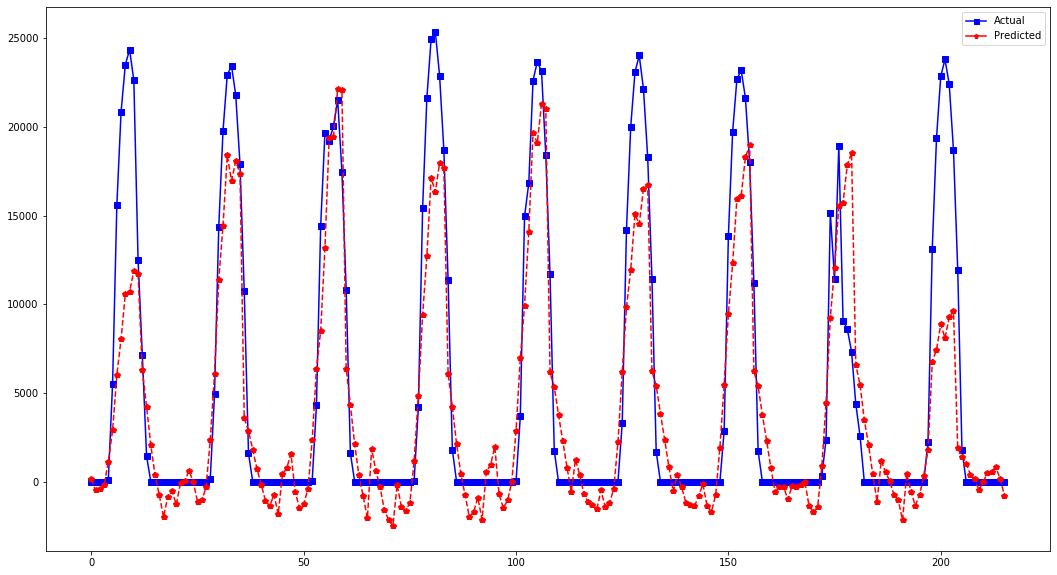

In [30]:
import matplotlib.lines as mlines

blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Actual')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Predicted')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(test_seq1, 'b-s')
plt.plot(pred_seq1, 'r--p')
plt.legend(handles=[blue_line, red_line])

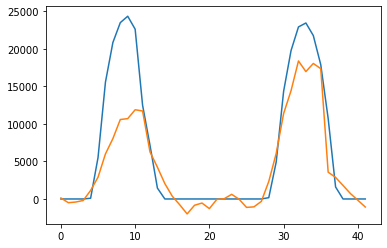

In [29]:
test_seq = np.concatenate((test_y[0], test_y[6], test_y[12], test_y[18], test_y[24], test_y[30], test_y[36]))
pred_seq = np.concatenate((predictions[0], predictions[6], predictions[12], predictions[18], predictions[24], predictions[30], predictions[36]))
plt.plot(test_seq)
plt.plot(pred_seq)

In [0]:
 from keras.utils import plot_model  
   
 ### Build, Load, and Compile your model  
   
 plot_model(model, to_file='model.png', show_layer_names=True)   